In [386]:
import numpy as np
import matplotlib.pyplot as plt
import reservoirpy as rpy
from reservoirpy.datasets import mackey_glass
from reservoirpy.nodes import Reservoir, Ridge, FORCE, ESN,Input
from reservoirpy.observables import mse

from numpy import *
import scipy as scp

In [387]:
rpy.verbosity(0)  # no need to be too verbose here
rpy.set_seed(42)  # make everything reproducible!

In [388]:
Data_set=np.load('data_set bretenberg.npy')
print(np.shape(Data_set))

(10000, 12)


In [389]:

X=Data_set[:,:8]
print(shape(X))  #+np.random.normal(loc=0,scale=1,size=(10000,8))
Y=Data_set[:,8].reshape((-1,1))

print(X[0,:8],Y[0])

(10000, 8)
[0.57917154 0.73806142 1.         1.         1.         1.
 0.74136532 0.57786862] [0.]


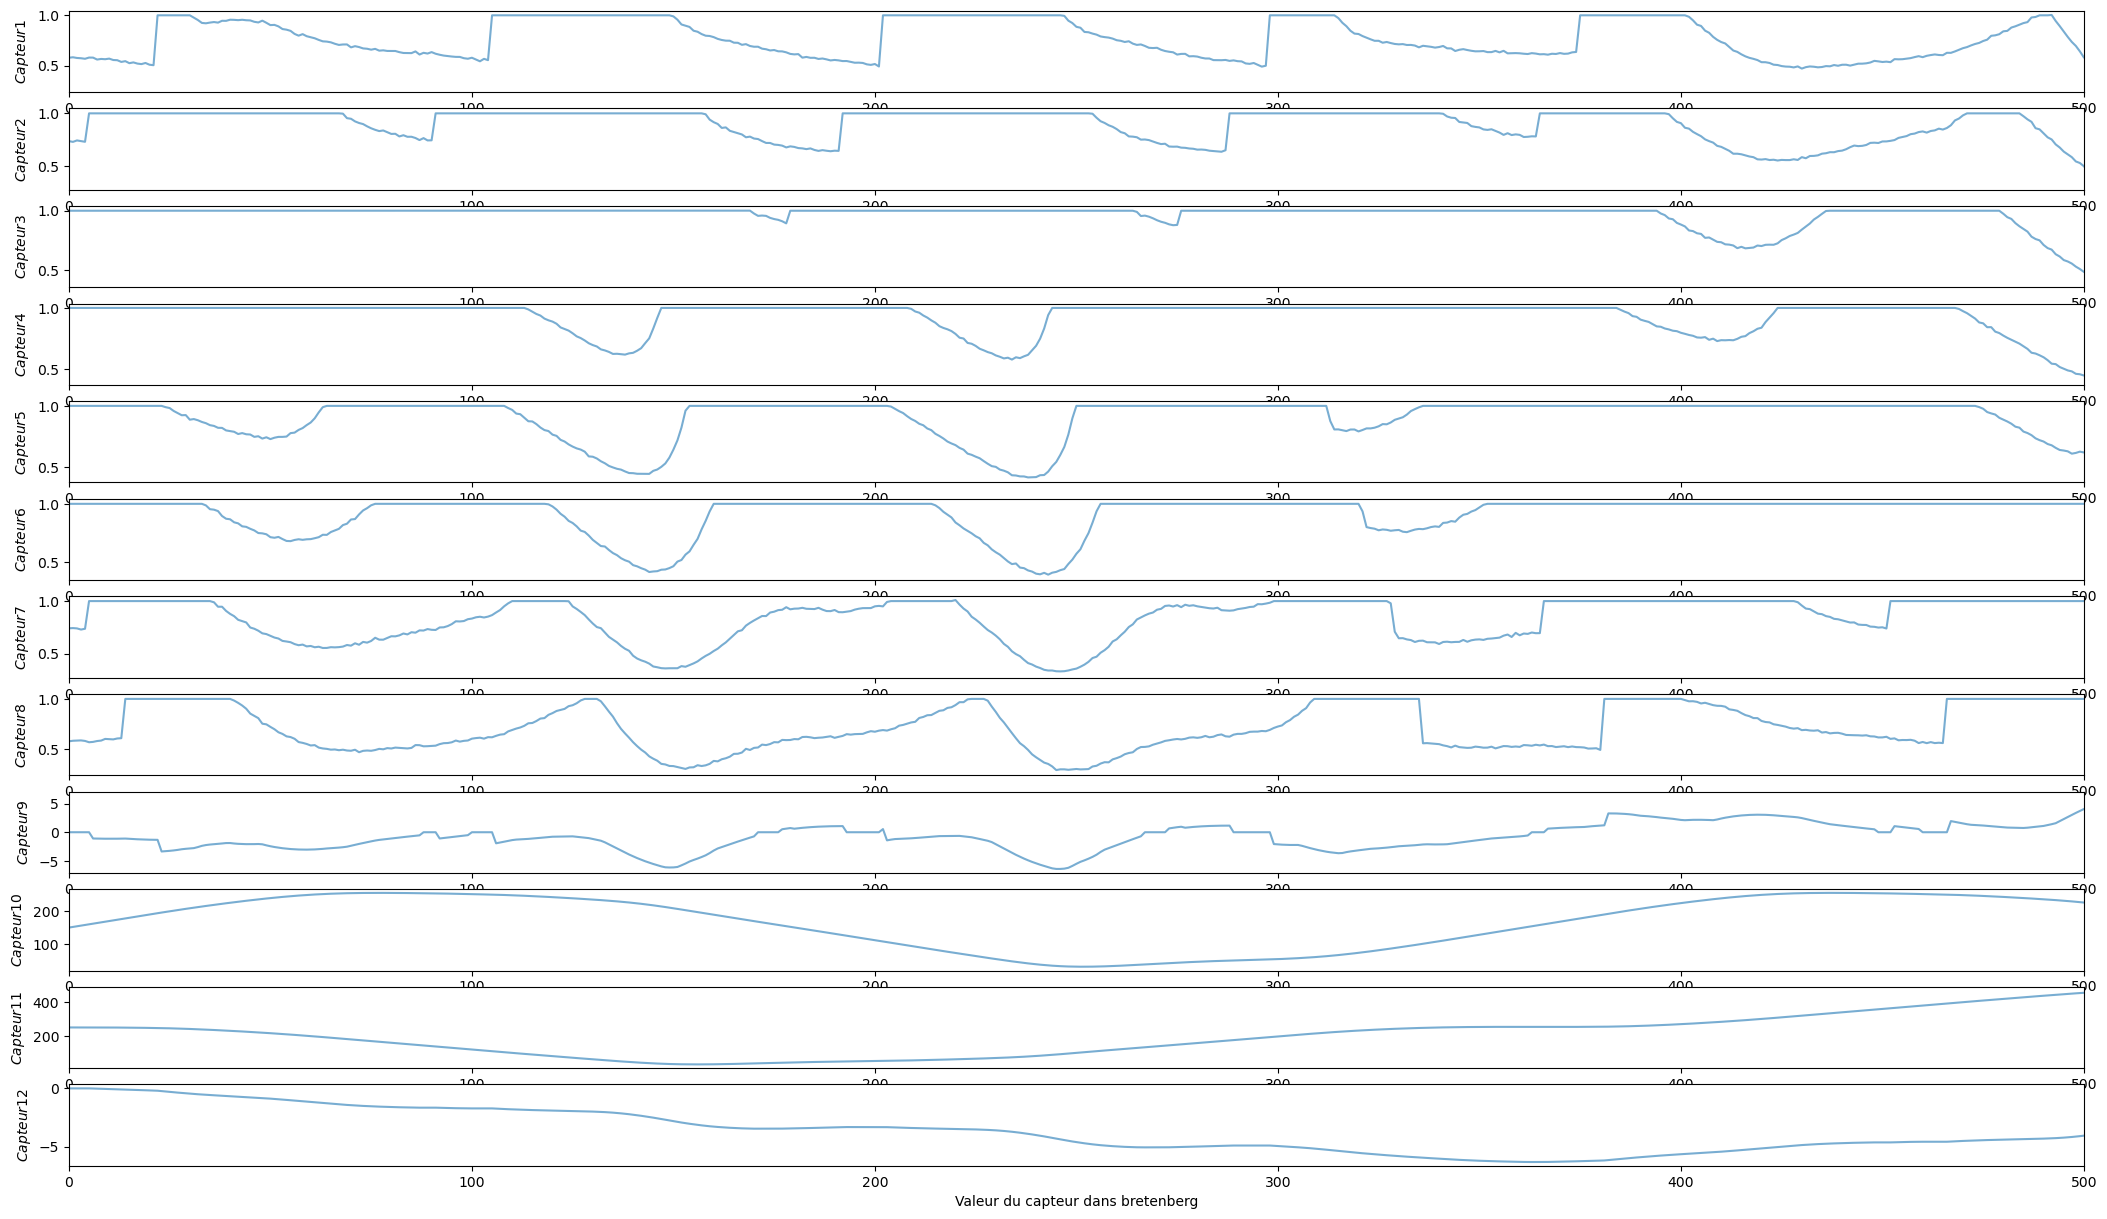

In [390]:
n_sensors=12
plt.figure(figsize=(26, 15))
for i in range(n_sensors):
    plt.subplot(n_sensors, 1, i+1)
    plt.plot(Data_set[:,i], alpha=0.6)
    plt.ylabel(f"$Capteur{i+1}$")
    plt.xlim((0,500))
plt.xlabel(f"Valeur du capteur dans bretenberg")
plt.show()

In [391]:
warmup=100

#data = Input(input_dim=8)
reservoir = Reservoir(units=1000,sr=1.05, lr=0.1 ,noise_rc=6e-5,input_connectivity=0.2,rc_connectivity=0.1, input_scaling=1,input_bias=True)
readout = Ridge(ridge=1e-6, output_dim=1,input_bias=True)
esn_model = reservoir >> readout
esn_model=esn_model.fit(X[:7500],Y[:7500],warmup=warmup)
print(reservoir.is_initialized, readout.is_initialized, readout.fitted)
Y_pred=esn_model.run(X[7500:],return_states=[reservoir.name,readout.name])
#mse(Y[7500:],Y_pred[readout.name])

True True True


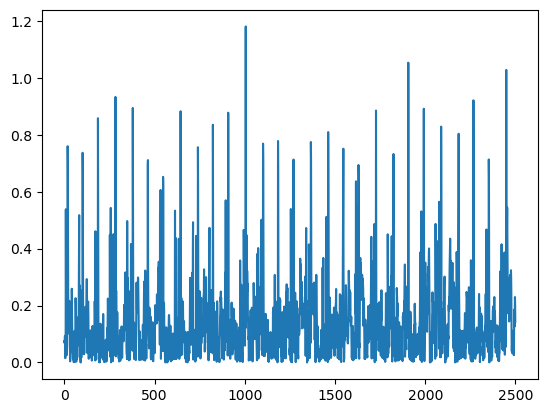

In [401]:
plt.plot(abs(Y[7500:]-Y_pred[readout.name]))

In [393]:
def line_intersect(p1, p2, P3, P4):
    # calcule les coordonnées des points d'intersections entre deux segments. Ici entre le rayon du senseur et du mur

    # on récupère les coodonnées de tous les segments que formé par les senseurs
    p1 = np.atleast_2d(p1) 
    p2 = np.atleast_2d(p2)
    # on récupère les coordonnées des segments des murs du labyrinthe
    P3 = np.atleast_2d(P3)
    P4 = np.atleast_2d(P4)
    

    x1, y1 = p1[:,0], p1[:,1]
    x2, y2 = p2[:,0], p2[:,1]
    X3, Y3 = P3[:,0], P3[:,1]
    X4, Y4 = P4[:,0], P4[:,1]

    #colinéarité entre le vecteur senseur et le mur 
    D = (Y4-Y3)*(x2-x1) - (X4-X3)*(y2-y1)

    # Colinearity test
    C = (D != 0)
    UA = ((X4-X3)*(y1-Y3) - (Y4-Y3)*(x1-X3))
    UA = np.divide(UA, D, where=C)
    UB = ((x2-x1)*(y1-Y3) - (y2-y1)*(x1-X3))
    UB = np.divide(UB, D, where=C)

    # Test if intersections are inside each segment
    C = C * (UA > 0) * (UA < 1) * (UB > 0) * (UB < 1)
    
    X = np.where(C, x1 + UA*(x2-x1), np.inf)
    Y = np.where(C, y1 + UA*(y2-y1), np.inf)
    return np.stack([X,Y],axis=1)

In [394]:
walls = np.array( [

            # Surrounding walls
            [ (  0,   0), (  0, 500)],
            [ (  0, 500), (300, 500)],
            [ (300, 500), (300,   0)],
            [ (300,   0), (  0,   0)],
            
            # Bottom hole
            [ (100, 100), (200, 100)],
            [ (200, 100), (200, 200)],
            [ (200, 200), (100, 200)],
            [ (100, 200), (100, 100)],

            # Top hole
            [ (100, 300), (200, 300)],
            [ (200, 300), (200, 400)],
            [ (200, 400), (100, 400)],
            [ (100, 400), (100, 300)]
        ] )
print(walls.shape)


(12, 2, 2)


In [395]:
theta=esn_model.run(Data_set[-1,:8])
print(theta)

[[4.69895686]]


In [396]:
A = np.linspace(-np.pi/2, +np.pi/2, 8, endpoint=True)
sensors = {
    "angle" : A,
    "range" : 75*np.ones((8,1)),
    "value" : np.ones((8,1)) }

sensors["range"][3:5] *= 1.25
print(sensors["range"])
orientation=np.array(Data_set[7500,11])
position=np.array([Data_set[7500,9],Data_set[7500,10]]).reshape((1,2))
position+= 2 * np.array([np.cos(float(orientation)),np.sin(float(orientation))]).reshape((1,2))
print(f'position:{position}')
print(f'orientation:{orientation}')
size=10
pred=2500
naomi=np.zeros((pred,13))
for n in range(pred):
    A = sensors["angle"] + orientation # angles de tous les senseurs
    T = np.stack([np.cos(A), np.sin(A)], axis=1) # gradient ? de tous les angles des senseurs
    P1 = position + size*T # positions dans le plan de tous les senseurs du robot
    P2 = P1 + sensors["range"]*T # coordonées de la fin du segment formé a partir du senseur et jusq'uà sa distance de vision
    P3, P4 = walls[:,0], walls[:,1] # coordonnées de tous les murs du labyrinthe 
    for i, (p1, p2) in enumerate(zip(P1,P2)): # pour tous les segments robot-range 
        C = line_intersect(p1, p2, P3, P4) # calcul du point d'intersection entre la vision et le mur du labyrinthe
        index = np.argmin( ((C - p1)**2).sum(axis=1)) # somme des distances au carré du robot aux intersections, on obtient le nom du senseur de plus petit distance au mur 
        p = C[index] # on récupère la plus petite distance au mur
        if p[0] < np.inf: # si la distance est finie alors:
            sensors["value"][i] = np.sqrt(((p1-p)**2).sum())+np.random.normal(loc=0,scale=1)
            sensors["value"][i] /= sensors["range"][i]
        else:
            sensors["value"][i] = 1
    naomi[n,:8]=sensors["value"].reshape((8,))
    dv=float(esn_model(naomi[n,:8]))
    if abs(theta) > 0.5:
        orientation += 0.015*dv
        #print(orientation)
    else: dv=0
    naomi[n,9]=dv
    position += 2 * np.array([np.cos(float(orientation)),np.sin(float(orientation))]).reshape((1,2))
    naomi[n,10],naomi[n,11]=position[0,0],position[0,1]
    naomi[n,12]=orientation


"""
for i in range(pred):
    A = sensors["angle"] + orientation # angles de tous les senseurs
    #print(A)
    T = np.stack([np.cos(A), np.sin(A)], axis=1).reshape((2,8))
    #print(T) # gradient ? de tous les angles des senseurs
    P1 = size*T +position*np.ones((2,8))# (8, 2)
    print(P1)
    P2 = P1 + T * sensors["range"].reshape((1,8)) 
    print(P2)
    #print(np.shape(list(zip(P1,P2))))          # (8, 2) # coordonées de la fin du segment formé a partir du senseur et jusq'uà sa distance de vision
    P3, P4 = walls[:,0], walls[:,1] # coordonnées de tous les murs du labyrinthe 
    for n, (p1, p2) in enumerate(np.stack([P1,P2],axis=1)): # pour tous les segments robot-range 
        C = line_intersect(p1, p2, P3, P4)
        print(p1)
        print(C) # calcul du point d'intersection entre la vision et le mur du labyrinthe
        index = np.argmin( ((C - p1)**2).sum(axis=1)) # somme des distances au carré du robot aux intersections, on obtient le nom du senseur de plus petit distance au mur 
        p = C[index] # on récupère la plus petite distance au mur
        if p[0] < np.inf: # si la distance est finie alors:
            naomi[i,n] = np.sqrt(((p1-p)**2).sum())
            naomi[i,n] /= sensors["range"][n]
            #self.sensors["value"][i]+=np.random.normal(loc=0,scale=0.5)
        else:
            naomi[i,n]= 1
    dv=esn_model.run(naomi[i,0:7])
    if abs(dv) > 0.5:
        orientation += 0.01*dv
        #print(orientation)
    else: dv=0
    naomi[i,8]=dv
    position += 2 * np.array([np.cos(float(orientation)),np.sin(float(orientation))]).reshape((2,1))
    naomi[i,9],naomi[i,10]=position
    naomi[i,11]=orientation"""

[[75.  ]
 [75.  ]
 [75.  ]
 [93.75]
 [93.75]
 [75.  ]
 [75.  ]
 [75.  ]]
position:[[ 46.60023947 160.10250089]]
orientation:-4.984672804031343


/var/folders/6m/nc11lc0140jdsjpbbmvlcw7m0000gn/T/ipykernel_4545/1626487069.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dv=float(esn_model(naomi[n,:8]))


'\nfor i in range(pred):\n    A = sensors["angle"] + orientation # angles de tous les senseurs\n    #print(A)\n    T = np.stack([np.cos(A), np.sin(A)], axis=1).reshape((2,8))\n    #print(T) # gradient ? de tous les angles des senseurs\n    P1 = size*T +position*np.ones((2,8))# (8, 2)\n    print(P1)\n    P2 = P1 + T * sensors["range"].reshape((1,8)) \n    print(P2)\n    #print(np.shape(list(zip(P1,P2))))          # (8, 2) # coordonées de la fin du segment formé a partir du senseur et jusq\'uà sa distance de vision\n    P3, P4 = walls[:,0], walls[:,1] # coordonnées de tous les murs du labyrinthe \n    for n, (p1, p2) in enumerate(np.stack([P1,P2],axis=1)): # pour tous les segments robot-range \n        C = line_intersect(p1, p2, P3, P4)\n        print(p1)\n        print(C) # calcul du point d\'intersection entre la vision et le mur du labyrinthe\n        index = np.argmin( ((C - p1)**2).sum(axis=1)) # somme des distances au carré du robot aux intersections, on obtient le nom du senseur d

In [397]:
print(Data_set[-1,0:7])
print(naomi[:3,0:7])


[0.2892508  0.39974484 0.68630113 1.         1.         1.
 1.        ]
[[0.61252017 0.58805785 0.75346602 1.         1.         1.
  0.71421871]
 [0.59104973 0.60787114 1.         1.         1.         1.
  0.69466515]
 [0.59292301 0.57607847 1.         1.         1.         1.
  0.67832168]]


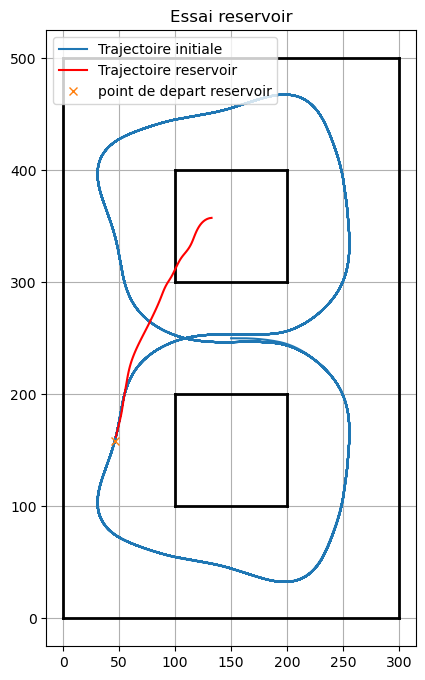

In [398]:
fig, ax = plt.subplots(figsize=(8, 8))

# Tracé des murs
for wall in walls:
    (x1, y1), (x2, y2) = wall
    ax.plot([x1, x2], [y1, y2], 'k-', linewidth=2)

# Tracé de la trajectoire du robot
ax.plot(Data_set[:7500,9],Data_set[:7500,10],label='Trajectoire initiale')
ax.plot(naomi[:110,10], naomi[:110,11], 'r-', label='Trajectoire reservoir')
ax.plot(Data_set[7500,9],Data_set[7500,10], 'x', label='point de depart reservoir')
# Options d'affich
##ax.set_xlim(0, 300)
#ax.set_ylim(0, 500)
ax.set_aspect('equal')
ax.set_title('Essai reservoir')
ax.legend()
plt.grid(True)
plt.show()

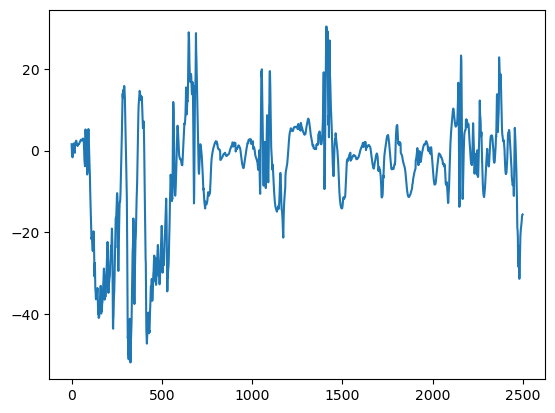

In [399]:
plt.plot(naomi[:,9]-Data_set[7500:,8])